 AC209a Twitter Project - Group 15

## Advance models with NLP features

<hr style="height:2pt">

In [1]:
%%capture
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Important packages

1. `Tweepy` - Twitter API - http://docs.tweepy.org/en/v3.5.0/api.html#tweepy-api-twitter-api-wrapper

2. `nltk` - Natural language processing library - http://www.nltk.org/howto/twitter.html

3. `twython` - Python wrapper for the Twitter API

4. `jsonpickle` - converts Python objects into JSON

5. `scikit-learn` - Python machine learning library

https://github.com/Jefferson-Henrique/GetOldTweets-python

In [2]:
%%capture
!pip install --upgrade jsonpickle tweepy

import sys
import jsonpickle
import os
import numpy as np
import pandas as pd
import tweepy
import nltk
import pandas as pd
import json
import sklearn
import datetime
from datetime import datetime
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pandas.io.json import json_normalize

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import tensorflow.keras 
from tensorflow.keras import models
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

from sklearn.metrics import r2_score as r2

from sklearn.utils import shuffle
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow.contrib.eager as tfe
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')
import time

## Data cleaning

In this part, we import datasets from previous section, split the dataset into training and test set and do data cleaning  by normalizing data in each columns. The feature we used here include feature we extracted from NLP.

In [212]:
user_df = pd.read_csv(r"merged_mean_imputed_legit.csv",index_col='User ID')
bot_df = pd.read_csv(r"merged_mean_imputed_bots.csv",index_col='User ID')
pre_df=pd.read_csv(r"merged_detect_df.csv",index_col='User ID')
bot_df['bot']=1
user_df['bot']=0
pre_df['bot']=2
total_df = bot_df.append(user_df)

In [213]:
total_df=total_df.drop(['bot_bool','Account age (days)','avg_num_caps', 'avg_words_per_tweet','word_diversity', 'difficult_words_score','avg_readability_combined_metric','avg_flesch_reading_ease', 'avg_readability_DC', 'full_tweet_text','avg_num_hashtags.1','percent_with_p_emoji','percent_with_n_emoji','percent_with_pn_emoji','avg_num_exclamation','avg_num_ellipses'],axis=1)

pre_df=pre_df.drop(['Account age (days)','avg_num_caps', 'avg_words_per_tweet','word_diversity', 'difficult_words_score','avg_readability_combined_metric','avg_flesch_reading_ease', 'avg_readability_DC', 'full_tweet_text','avg_num_hashtags.1','avg_num_exclamation','avg_num_ellipses'],axis=1)


In [214]:
all_df=total_df.append(pre_df)
all_df=pd.get_dummies(all_df, prefix=['overall_language'], columns=['overall_language'])
pre_df_new=all_df[all_df['bot']==2].drop(['bot'],axis=1)
user_df_new=all_df[all_df['bot']==0]
bot_df_new=all_df[all_df['bot']==1]
total_df_new = bot_df_new.append(user_df_new)

In [215]:
total_df_new.shape

(2691, 55)

In [216]:
pre_df_new.shape

(897, 54)

In [412]:
train_data, test_data = train_test_split(total_df_new, test_size = 0.3, random_state=99)
Y_train=train_data['bot']
Y_test=test_data['bot']
X_train=train_data.drop('bot',axis=1)
X_test=test_data.drop('bot',axis=1)

In [413]:
X_test=X_test.replace([np.inf, -np.inf], np.nan).dropna()
X_train=X_train.replace([np.inf, -np.inf], np.nan).dropna()
pre_df_new=pre_df_new.replace([np.inf, -np.inf], np.nan).dropna()

In [414]:
def normalize(df,df_train):
    result = df.copy()
    for feature_name in df_train.columns:
        max_value = df_train[feature_name].max()
        min_value = df_train[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [415]:
X_train_scaled=normalize(X_train,X_train)
X_test_scaled=normalize(X_test,X_train)
pre_df_scaled=normalize(pre_df_new,X_train)
# X_train=X_train.drop(['overall_language_bg','overall_language_fa','overall_language_lv','overall_language_lv','overall_language_sw'],axis=1)
# X_test=X_test.drop(['overall_language_bg','overall_language_fa','overall_language_lv','overall_language_lv','overall_language_sw'],axis=1)

In [416]:
X_train_scaled=X_train_scaled.drop(['overall_language_bg','overall_language_fa','overall_language_lv','overall_language_lv','overall_language_sw'],axis=1)
X_test_scaled=X_test_scaled.drop(['overall_language_bg','overall_language_fa','overall_language_lv','overall_language_lv','overall_language_sw'],axis=1)
pre_df_scaled=pre_df_scaled.drop(['overall_language_bg','overall_language_fa','overall_language_lv','overall_language_lv','overall_language_sw'],axis=1)


In [417]:
pre_scaled.describe()

,Default picture (binary),Default profile (binary),Number of digits in screen name,Number of favorites,Number of followers,Number of friends,Number of tweets per hour,Number of tweets total,Number of unique profile descriptions,Screen name length,...,overall_language_ml,overall_language_nl,overall_language_no,overall_language_pt,overall_language_ro,overall_language_ru,overall_language_sv,overall_language_th,overall_language_tr,overall_language_zh-cn
count,869.000000,869.000000,869.000000,869.000000,8.690000e+02,869.000000,869.000000,869.000000,869.000000,869.000000,...,869.0,869.000000,869.000000,869.000000,869.0,869.000000,869.0,869.0,869.000000,869.0
mean,0.074799,0.642117,0.131473,0.086122,3.693315e-04,0.015087,0.211224,0.062144,0.078959,0.690183,...,0.0,0.004603,0.001151,0.005754,0.0,0.001151,0.0,0.0,0.002301,0.0
std,0.263218,0.479653,0.233956,0.133814,2.052938e-03,0.033909,0.362356,0.108262,0.134112,0.205873,...,0.0,0.067728,0.033923,0.075678,0.0,0.033923,0.0,0.0,0.047946,0.0
min,0.000000,0.000000,0.000000,0.000002,-1.489155e-07,0.000000,0.000106,0.000046,0.000000,0.153846,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.010240,1.295565e-05,0.001481,0.023991,0.006929,0.000000,0.538462,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,0.000000,1.000000,0.000000,0.037432,4.340887e-05,0.004741,0.082180,0.025644,0.000000,0.692308,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,0.000000,1.000000,0.250000,0.102345,1.734121e-04,0.015293,0.222146,0.072072,0.076923,0.846154,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1.000000,1.000000,1.500000,1.213595,4.007606e-02,0.336010,3.348756,1.224379,0.923077,1.000000,...,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.0


# Models  with  NLP Features

Similar to the that in the model development,we also use Logistic Regression, LDA/QDA, Random Forest,Boosting, and Support Vector Machines models. 

Two major improvements from what we did in the model development section are:

* Include features from NLP into these models;

* Include Feed Forward Artificial Neural Network; Stacking (Meta Ensembling) and Blended Ensemble Methods in the model.

## Logistic Regression

In [418]:
start_time = time.time()
logreg = LogisticRegression(C=100000,fit_intercept=True).fit(X_train_scaled,Y_train)
time_logistic=time.time() - start_time
logreg_train = logreg.score(X_train_scaled, Y_train)
logreg_test = logreg.score(X_test_scaled, Y_test)
print('Accuracy of logistic regression model on the test set is {:.3f}'.format(logreg_test))

Accuracy of logistic regression model on the test set is 0.972


In [419]:
# Logistic regression w/ quadratic + interaction terms + regularization
start_time = time.time()
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True),
    LogisticRegressionCV(multi_class="ovr", penalty='l2', cv=5, max_iter=10000))
linearLogCVpoly = polynomial_logreg_estimator.fit(X_train_scaled, Y_train)
time_linearLogCVpoly=time.time() - start_time

# Compare results
print('Polynomial-logistic accuracy:test={:.1%}'.format( linearLogCVpoly.score(X_test_scaled, Y_test)))

linearLogCVpoly_train = linearLogCVpoly.score(X_train_scaled, Y_train)
linearLogCVpoly_test = linearLogCVpoly.score(X_test_scaled, Y_test)

Polynomial-logistic accuracy:test=96.9%


In [420]:
y_pred_logreg= logreg.predict(X_test_scaled)
y_pred_logreg_proba=logreg.predict_proba(X_test_scaled)[:,1]
y_pred_linearLogCVpoly= linearLogCVpoly.predict(X_test_scaled)
y_pred_linearLogCVpoly_proba=linearLogCVpoly.predict_proba(X_test_scaled)[:,1]


y_pre_df_logreg= logreg.predict(pre_df_scaled)
y_pre_df_logreg_proba=logreg.predict_proba(pre_df_scaled)[:,1]
y_pre_df_linearLogCVpoly= linearLogCVpoly.predict(pre_df_scaled)
y_pre_df_linearLogCVpoly_proba=linearLogCVpoly.predict_proba(pre_df_scaled)[:,1]

In [421]:
y_pre_df_linearLogCVpoly.nonzero()

(array([  2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  15,  32,  36,
         40,  45,  49,  58,  59,  63,  65,  66,  69,  70,  71,  72,  73,
         80,  93,  94,  99, 100, 101, 102, 103, 106, 108, 109, 112, 113,
        115, 116, 129, 133, 139, 140, 142, 147, 148, 155, 160, 161, 168,
        172, 173, 183, 187, 193, 201, 202, 212, 218, 223, 225, 227, 231,
        242, 243, 250, 259, 274, 277, 278, 281, 285, 287, 288, 290, 292,
        293, 295, 307, 313, 317, 321, 322, 323, 324, 332, 335, 336, 338,
        340, 341, 344, 346, 351, 363, 369, 381, 392, 393, 394, 396, 398,
        399, 401, 404, 410, 415, 418, 423, 427, 431, 437, 440, 442, 449,
        450, 457, 464, 465, 468, 471, 478, 487, 488, 491, 506, 507, 509,
        510, 511, 513, 515, 517, 533, 537, 542, 547, 548, 561, 565, 569,
        576, 577, 579, 580, 586, 590, 591, 593, 594, 595, 601, 609, 613,
        627, 632, 633, 650, 653, 654, 655, 659, 668, 670, 674, 675, 679,
        688, 696, 701, 703, 704, 710, 712, 715, 722

## LDA and QDA Model

In [423]:
start_time = time.time()
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train_scaled, Y_train)
time_lda=time.time() - start_time
print("---lda %s seconds ---" % (time_lda))

start_time = time.time()
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_scaled, Y_train)
time_qda=time.time() - start_time
print("--- qda %s seconds ---" % (time_qda))

y_pre_df_lda=lda.predict(pre_df_scaled)
y_pre_df_lda_proba=lda.predict_proba(pre_df_scaled)[:,1]

y_pred_qda=qda.predict(X_test_scaled)
lda_train = lda.score(X_train_scaled, Y_train)
lda_test = lda.score(X_test_scaled, Y_test)
qda_train = qda.score(X_train_scaled, Y_train)
y_pred_qda_proba=qda.predict_proba(X_test_scaled)[:,1]

qda_test = qda.score(X_test_scaled, Y_test)

print('LDA accuracy train={:.1%}, test: {:.1%}'.format(
    lda.score(X_train_scaled, Y_train), lda.score(X_test_scaled, Y_test)))

print('QDA accuracy train={:.1%}, test: {:.1%}'.format(
    qda.score(X_train_scaled, Y_train), qda.score(X_test_scaled, Y_test)))

---lda 0.014118194580078125 seconds ---
--- qda 0.00852203369140625 seconds ---
LDA accuracy train=94.5%, test: 93.2%
QDA accuracy train=73.0%, test: 72.8%


## Random forest

In [229]:
start_time = time.time()
ntrees = 50
rf = RandomForestClassifier(n_estimators=ntrees , max_depth=15, max_features='auto')
rf.fit(X_train_scaled, Y_train)

time_rf=time.time() - start_time
print("--- %s seconds ---" % (time_rf))

rf_train =rf.score(X_train_scaled, Y_train)
rf_test =rf.score(X_test_scaled, Y_test)
rf_y_test_proba =rf.predict_proba(X_test_scaled)[:,1]
rf_y_test =rf.predict(X_test_scaled)
print('RF accuracy train={:.1%}, test: {:.1%}'.format(rf_train,rf_test))
y_pre_df_rf = rf.predict(pre_df_scaled)

--- 0.24376201629638672 seconds ---
RF accuracy train=100.0%, test: 98.1%


In [297]:
y_pre_df_rf_proba =rf.predict_proba(pre_df_scaled)[:,1]


## Adaboost

In [233]:
start_time = time.time()

adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=800, learning_rate=0.01)
adaboost.fit(X_train_scaled, Y_train);
time_adaboost=time.time() - start_time
print("--- %s seconds ---" % (time_adaboost))

--- 19.226351022720337 seconds ---


In [234]:
y_pred_test = adaboost.predict(X_test_scaled)
pred_adaboost = [round(value) for value in y_pred_test]
test_adaboost = accuracy_score(Y_test, pred_adaboost)
print('test acc:',test_adaboost )
y_train_adaboost = adaboost.predict(X_train_scaled)
train_adaboost = accuracy_score(Y_train,y_train_adaboost)
y_test_adaboost = adaboost.predict(X_test_scaled)
y_test_adaboost_proba = adaboost.predict_proba(X_test_scaled)[:,1]


test acc: 0.9702970297029703


In [304]:
y_pre_df_adaboost = adaboost.predict(pre_df_scaled)
y_pre_df_adaboost.nonzero()
y_pre_df_adaboost_proba=rf.predict_proba(pre_df_scaled)[:,1]


## XGBoost

In [473]:

import xgboost as xgb
from sklearn.metrics import confusion_matrix



start_time = time.time()
xgb = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01).fit(X_train_scaled, Y_train)
time_xgb=time.time() - start_time
print("--- %s seconds ---" % (time_xgb))

y_pred_train_xgb = xgb.predict(X_train_scaled)
y_pred_test_xgb = xgb.predict(X_test_scaled)
y_pred_test_xgb_proba = xgb.predict_proba(X_test_scaled)[:,1]

# test_xgb = accuracy_score(Y_test, y_pred_test_xgb)
# train_xgb = accuracy_score(Y_test, y_pred_test_xgb)

# print("test Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

y_pre_df_xgboost = xgb.predict(pre_df_scaled)


--- 2.580984115600586 seconds ---


In [477]:

y_pre_df_xgboost_proba= xgb.predict_proba(pre_df_scaled)[:,1]


In [478]:
y_pre_df_xgboost_proba.shape

(869,)

## K-NN

In [258]:
start_time = time.time()

scores_mean=[]
scores_std=[]
k_number=np.arange(1,40)
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = k)
    score_mean= cross_val_score(knn,X_train_scaled,Y_train,cv=5).mean()
    score_std=cross_val_score(knn,X_train_scaled,Y_train,cv=5).std()
    scores_mean.append(score_mean)
max_score_k=max(scores_mean)
best_k=scores_mean.index(max(scores_mean))+1
print('Best K=',best_k, 'with a max CV score of',max_score_k)

knn_best_k = KNeighborsClassifier(n_neighbors = best_k)
knn_best_k.fit(X_train_scaled,Y_train);

time_knn_best_k=time.time() - start_time
print("--- %s seconds ---" % (time_knn_best_k))

y_test_pred_best_k = knn_best_k.predict(X_test_scaled)
y_train_pred_best_k = knn_best_k.predict(X_train_scaled)
y_test_pred_best_k_proba = knn_best_k.predict_proba(X_test_scaled)[:,1]

train_knn_best_k= knn_best_k.score(X_train_scaled, Y_train)
test_knn_best_k= knn_best_k.score(X_test_scaled, Y_test)

print('train accuracy',accuracy_score(Y_train, y_train_pred_best_k))
print('test accuracy',accuracy_score(Y_test, y_test_pred_best_k))

Best K= 4 with a max CV score of 0.9522094926350245
--- 21.24043893814087 seconds ---
train accuracy 0.9681359532660648
test accuracy 0.9492574257425742


In [382]:
y_pred_df_best_k = knn_best_k.predict(pre_df_scaled)
y_pre_df_adaboost.nonzero()
y_pred_df_best_k_proba = knn_best_k.predict_proba(pre_df_scaled)[:,1]


In [383]:
y_pred_df_best_k_proba

array([0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ,
       0.  , 0.  , 0.  , 0.5 , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.5 , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ,
       0.75, 0.  , 0.  , 0.5 , 0.5 , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.25,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.5 , 0.5 , 0.25,
       0.5 , 0.  , 0.25, 0.5 , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.75, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

## Support Vector Machines

In [427]:
def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test,pre_df, C):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='linear',probability=True)
    model.fit(x_train, y_train)
    
    # Train and test error

    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)
    y_pre_svm = model.predict(pre_df)
    y_pre_svm_proba = model.predict_proba(pre_df)[:,1]

    return tr_acc, ts_acc,y_pre_svm,y_pre_svm_proba

In [428]:
# Fit and plot for different 'C' values
start_time = time.time()
tr_acc, ts_acc,y_pre_df_svm,y_pre_dfsvm_proba = fit_and_plot_svm_for_c(X_train_scaled, Y_train,X_test_scaled, Y_test, pre_df_scaled, 0.1)
time_svm=time.time() - start_time
print("--- %s seconds ---" % (time_svm))

--- 0.5375940799713135 seconds ---


In [430]:
y_pre_df_svm

(array([ 94,  99, 103, 125, 151, 155, 205, 219, 270, 282, 284, 333, 336,
        357, 385, 416, 453, 454, 471, 500, 521, 671, 682, 698, 722, 733,
        738, 743, 744, 798, 839, 846]),)

In [429]:
print('train accuracy',tr_acc)
print('test accuracy',ts_acc)

train accuracy 0.9251194901752523
test accuracy 0.9133663366336634


## Artificial Neural network (ANN)


In this section, we development Artificial neural network based on TensorFlow.
Neural Networks consist of the following components:
* An input layer, x
* An arbitrary amount of hidden layers
* An output layer, ŷ
* A set of weights and biases between each layer, W and b
* A choice of activation function for each hidden layer, σ.


Here we built a three-layers ANN based on GridsearchCV results :
1. Nodes per Layer: 500,300,2 
2. Activation function: reLU
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: Adam
6. Epochs: 500
7. Batch size: 128
8. Validation size: .2


In [366]:
start_time=time.time()
model_NN = models.Sequential()

model_NN.add(layers.Dense(500, input_shape=(X_train_scaled.shape[1],),
                activation='relu'))

model_NN.add(layers.Dense(300, input_shape=(X_train_scaled.shape[1],),
                activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model_NN.add(Dropout(0.5))

model_NN.add(layers.Dense(1,  
                activation='sigmoid')) 

print(model_NN.summary())
tensorflow.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_NN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 176,101
Trainable params: 176,101
Non-trainable params: 0
_________________________________________________________________
None


In [367]:
%%capture
start_time=time.time()
ANN_history = model_NN.fit(X_train_scaled, Y_train,batch_size=128,epochs=500,validation_split=0.2)
time_ANN=time.time() - start_time

808/808 [==============================] - 0s 42us/step
Test loss: 0.13090957977836676
Test ACC: 0.9789603960396039


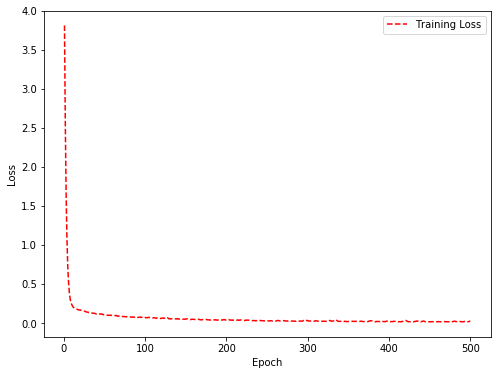

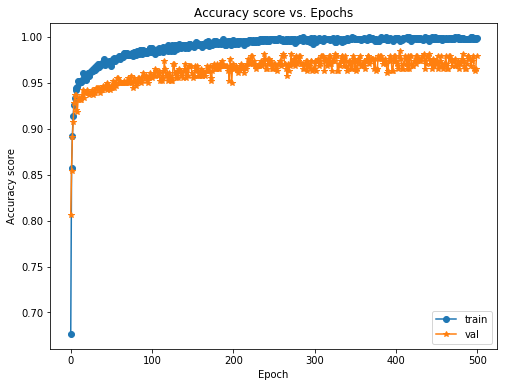

In [480]:
train_loss,train_acc = model_NN.evaluate(X_train_scaled, Y_train, verbose=1)
test_loss,test_acc = model_NN.evaluate(X_test_scaled, Y_test, verbose=1)
print('Test loss:', test_loss)
print('Test ACC:', test_acc)
y_pre_test_NN_proba = model_NN.predict(X_test_scaled)
y_pre_test_NN= np.array((y_pre_test_NN_proba>0.5).astype(np.int))[:,0]
training_loss = ANN_history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
fig, axs = plt.subplots(figsize=(8, 6))

plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();
fig, axs = plt.subplots(figsize=(8, 6))
plt.plot(ANN_history.history['acc'], '-o', label='train')
plt.plot(ANN_history.history['val_acc'], '-*', label='val')

plt.ylabel("Accuracy score")
plt.xlabel("Epoch")
plt.title("Accuracy score vs. Epochs")

plt.legend()
plt.show() 

In [371]:
y_pre_df_NN_proba = model_NN.predict(pre_df_scaled)
y_pre_df_NN= np.array((y_pre_df_NN_proba>0.5).astype(np.int))[:,0]

In [372]:
sum(y_pre_df_NN==1)/len(y_pre_df_NN)

0.13578826237054084

In [373]:
y_pre_df_NN.nonzero()

(array([  2,   3,   6,   7,   9,  10,  12,  15,  24,  36,  40,  49,  63,
         71,  73,  93,  94,  99, 100, 102, 103, 106, 109, 115, 116, 133,
        134, 135, 142, 155, 157, 172, 183, 193, 198, 212, 213, 218, 223,
        225, 227, 258, 270, 274, 277, 281, 285, 288, 293, 295, 314, 322,
        332, 336, 345, 346, 351, 393, 398, 399, 415, 427, 431, 450, 465,
        478, 506, 509, 510, 524, 533, 537, 547, 548, 565, 579, 580, 586,
        593, 595, 613, 624, 627, 632, 633, 650, 653, 654, 655, 664, 668,
        674, 675, 679, 694, 703, 704, 722, 730, 737, 738, 744, 749, 751,
        766, 767, 768, 805, 809, 813, 815, 835, 840, 844, 845, 852, 856,
        863]),)

## Stacked Model

Model stacking is an efficient ensemble method in which the predictions, generated by using various machine learning algorithms, are used as inputs in a second-layer learning algorithm. This second-layer algorithm is trained to optimally combine the model predictions to form a new set of predictions. For example, when linear regression is used as second-layer modeling, it estimates these weights by minimizing the least square errors. However, the second-layer modeling is not restricted to only linear models; the relationship between the predictors can be more complex, opening the door to employing other machine learning algorithms.

![title](modelstacking.png)

Ensemble modeling and model stacking are especially popular in data science competitions, in which a sponsor posts a training set (which includes labels) and a test set (which does not include labels) and issues a global challenge to produce the best predictions of the test set for a specified performance criterion. The winning teams almost always use ensemble models instead of a single fine-tuned model. Often individual teams develop their own ensemble models in the early stages of the competition, and then join their forces in the later stages. 

Another popular data science competition is the KDD Cup. The following figure shows the winning solution for the 2015 competition, which used a three-stage stacked modeling approach. A similar approach will be trialed for this project to try and obtain maximal predictive capability.

![title](stackedapproach.png)

The figure shows that a diverse set of 64 single models were used to build the model library. These models are trained by using various machine learning algorithms. For example, the green boxes represent gradient boosting models (GBM), pink boxes represent neural network models (NN), and orange boxes represent factorization machines models (FM). You can see that there are multiple gradient boosting models in the model library; they probably vary in their use of different hyperparameter settings and/or feature sets.

A simple way to enhance diversity is to train models by using different machine learning algorithms. For example, adding a factorization model to a set of tree-based models (such as random forest and gradient boosting) provides a nice diversity because a factorization model is trained very differently than decision tree models are trained. For the same machine learning algorithm, you can enhance diversity by using different hyperparameter settings and subsets of variables. If you have many features, one efficient method is to choose subsets of the variables by simple random sampling.

Overfitting is an especially big problem in model stacking, because so many predictors that all predict the same target are combined. Overfitting is partially caused by this collinearity between the predictors. The most efficient techniques for training models (especially during the stacking stages) include using cross validation and some form of regularization. A good paper that outlines this procedure is [Stacked Ensemble Models for Improved Prediction Accuracy](https://support.sas.com/resources/papers/proceedings17/SAS0437-2017.pdf).

That paper also shows how you can generate a diverse set of models by various methods (such as forests, gradient boosted decision trees, factorization machines, and logistic regression) and then combine them with stacked ensemble techniques such regularized regression methods, gradient boosting, and hill climbing methods.

![title](levels.png)

Applying stacked models to real-world big data problems can produce greater prediction accuracy and robustness than do individual models. The model stacking approach is powerful and compelling enough to alter your initial data mining mindset from finding the single best model to finding a collection of really good complementary models. Of course, this method does involve additional cost both because you need to train a large number of models and because you need to use cross validation to avoid overfitting.

## Stacked Model

In this section we will try to implement a stacked model similar to that proposed in the "[Stacked Ensemble Models for Improved Prediction Accuracy](https://support.sas.com/resources/papers/proceedings17/SAS0437-2017.pdf)" paper.

In [384]:
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

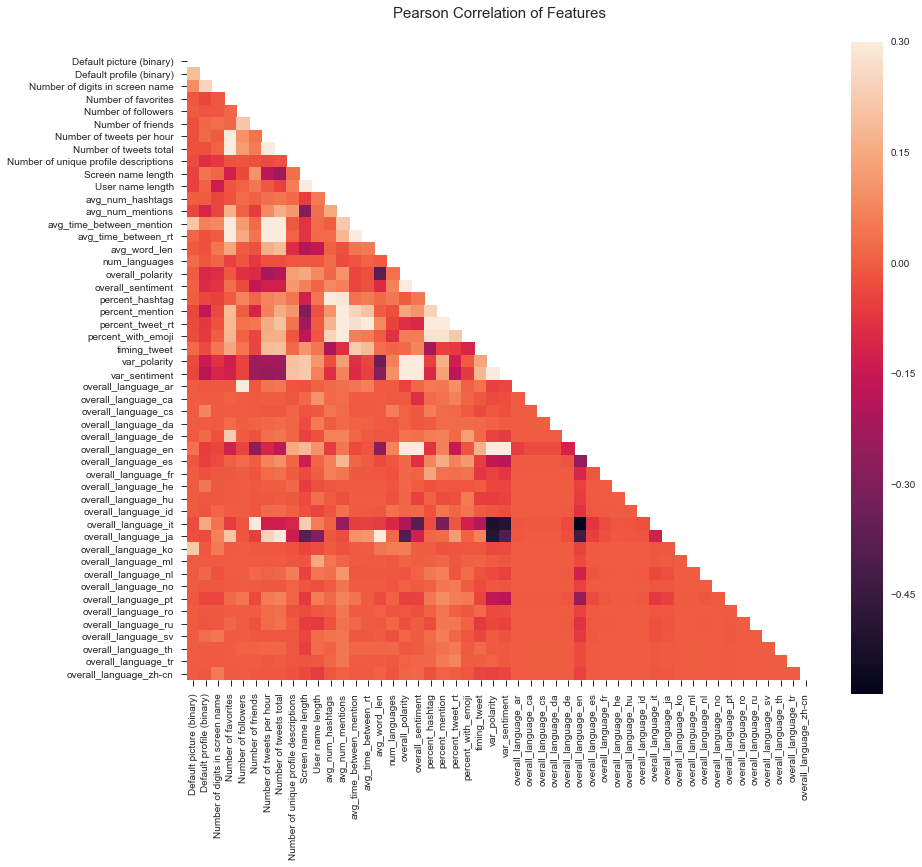

In [385]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
# Generate a mask for the upper triangle
corr = X_train_scaled.astype(float).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#mask = np.zeros_like(X_train_scaled)
#mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
#sns.heatmap(X_train_scaled.astype(float).corr(),linewidths=0.1,vmax=1.0,
#            square=True, cmap=colormap, linecolor='white', annot=True)

## Helpers via Python Classes

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [386]:
# Some useful parameters which will come in handy later on
ntrain = X_train_scaled.shape[0]
ntest = pre_df_scaled.shape[0]

# ntest = X_test_scaled.shape[0]
SEED = 99 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

kf = KFold(n_splits = NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
            print(self.clf.fit(x,y).feature_importances_)

**def init :** Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

### Out-of-Fold Predictions

Stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [387]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):

        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Generating our Base First-Level Models

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

- **Random Forest classifier**
- **Extra Trees classifier**
- **AdaBoost classifer**
- **Gradient Boosting classifer**
- **Support Vector Machine**

**Parameters**

**n_jobs :** Number of cores used for the training process. If set to -1, all cores are used.

**n_estimators :** Number of classification trees in your learning model ( set to 10 per default)

**max_depth :** Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

**verbose :** Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

In [388]:
# Create 5 objects that represent our 4 models
# Put in our parameters for said classifiers
# Random Forest parameters

rf_params = {
    'n_jobs': -1,
    'n_estimators': 50,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 15,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}


# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'base_estimator': DecisionTreeClassifier(max_depth=5),
    'n_estimators': 800,
    'learning_rate' : 0.01
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'sigmoid',
    'C' : 0.1
    }

logreg_params = {'C':100000, 'fit_intercept': True}
lda_params = {'store_covariance': True}
qda_params = {'store_covariance': True}
polylogreg_params = {}

Let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [389]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
logreg_stack = SklearnHelper(clf=LogisticRegression, seed=SEED, params=logreg_params)
#lda_stack = SklearnHelper(clf=LinearDiscriminantAnalysis, params=lda_params)
#qda_stack = SklearnHelper(clf=QuadraticDiscriminantAnalysis, params=qda_params)
#polylogreg_stack = SklearnHelper(clf=polynomial_logreg_estimator, seed=SEED, params=polylogreg_params)


### Output of the First level Predictions

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [390]:
# Create our OOF train and test predictions. These base results will be used as new features
start_time = time.time()
et_oof_train, et_oof_test = get_oof(et, X_train_scaled, Y_train, pre_df_scaled) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train_scaled, Y_train, pre_df_scaled) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train_scaled, Y_train, pre_df_scaled) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train_scaled, Y_train, pre_df_scaled) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,X_train_scaled, Y_train, pre_df_scaled) # Support Vector Classifier
logreg_oof_train, logreg_oof_test = get_oof(logreg_stack,X_train_scaled, Y_train, pre_df_scaled) # Linear Logistic 
print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in .featureimportances. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [391]:
rf_feature = rf.feature_importances(X_train_scaled,Y_train);
et_feature = et.feature_importances(X_train_scaled, Y_train);
ada_feature = ada.feature_importances(X_train_scaled, Y_train);
gb_feature = gb.feature_importances(X_train_scaled,Y_train);

[2.99820848e-04 3.33703572e-03 7.97657248e-04 1.00614340e-01
 5.57319543e-02 3.00992072e-02 3.22908231e-02 9.06813254e-02
 8.36800572e-04 5.22490858e-02 7.61219715e-03 1.48934407e-02
 7.39058560e-02 3.19441773e-02 4.97628298e-02 7.86673186e-03
 2.44522814e-03 7.82286277e-03 7.42717518e-03 4.06614359e-02
 8.00965525e-02 5.07671247e-02 1.72730865e-01 1.37202264e-02
 1.35886490e-02 1.88678795e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.83064927e-03
 2.11202888e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.58607950e-05 2.36440310e-02 8.00544328e-03 2.35406125e-04
 0.00000000e+00 3.15386960e-07 0.00000000e+00 1.56196426e-03
 0.00000000e+00 4.33845320e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[5.42720478e-04 2.93301142e-03 1.04649178e-03 8.54776265e-03
 4.09555298e-04 4.81620767e-03 1.14880388e-02 3.62053961e-02
 7.69745927e-04 1.11209482e-01 1.52488141e-02 1.21193454e-02
 5.90972618e-02 7.98471692e-03 6.47859452e-03 8.42019

In [392]:
rf_feature =[2.99820848e-04, 3.33703572e-03, 7.97657248e-04, 1.00614340e-01,
 5.57319543e-02, 3.00992072e-02, 3.22908231e-02, 9.06813254e-02,
 8.36800572e-04, 5.22490858e-02, 7.61219715e-03, 1.48934407e-02,
 7.39058560e-02, 3.19441773e-02, 4.97628298e-02, 7.86673186e-03,
 2.44522814e-03, 7.82286277e-03, 7.42717518e-03, 4.06614359e-02,
 8.00965525e-02, 5.07671247e-02, 1.72730865e-01, 1.37202264e-02,
 1.35886490e-02, 1.88678795e-02 ,0.00000000e+00, 0.00000000e+00,
 0.00000000e+00 ,0.00000000e+00 ,0.00000000e+00, 4.83064927e-03,
 2.11202888e-04 ,0.00000000e+00 ,0.00000000e+00 ,0.00000000e+00,
 2.58607950e-05 ,2.36440310e-02 ,8.00544328e-03 ,2.35406125e-04,
 0.00000000e+00 ,3.15386960e-07 ,0.00000000e+00 ,1.56196426e-03,
 0.00000000e+00 ,4.33845320e-04 ,0.00000000e+00 ,0.00000000e+00,
 0.00000000e+00 ,0.00000000e+00]
et_feature=[5.42720478e-04, 2.93301142e-03, 1.04649178e-03, 8.54776265e-03,
 4.09555298e-04, 4.81620767e-03, 1.14880388e-02, 3.62053961e-02,
 7.69745927e-04, 1.11209482e-01, 1.52488141e-02, 1.21193454e-02,
 5.90972618e-02, 7.98471692e-03, 6.47859452e-03, 8.42019973e-03,
 9.90361334e-04, 8.26846377e-03, 2.28491329e-03 ,4.09031193e-02,
 1.46742963e-01, 7.00247289e-02, 2.86880722e-02, 3.55452105e-02,
 3.58302642e-02, 3.86362752e-02 ,3.81197634e-05, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 2.42432970e-03, 3.81216421e-02,
 2.21701811e-02, 1.42151356e-03, 0.00000000e+00, 1.20726166e-04,
 1.41002225e-04, 1.08759082e-01, 9.81538398e-02, 2.82048446e-05,
 0.00000000e+00, 2.21879689e-03, 2.65817978e-06, 3.07676681e-02,
 0.00000000e+00, 2.83195654e-04, 1.03270896e-04, 0.00000000e+00,
 0.00000000e+00, 1.40521922e-05]
ada_feature =[0.00000000e+00, 1.82441136e-04, 4.21116110e-06, 8.02186693e-03,
 1.43489691e-03, 6.82330498e-04, 1.86085436e-04, 7.06798237e-03,
 2.92700539e-06 ,1.19652815e-03, 1.75875738e-03, 2.71471588e-04,
 7.30595364e-03, 1.83129538e-03, 2.76280081e-03, 1.24637827e-03,
 1.04500033e-03, 1.17669965e-04, 3.40438268e-04, 1.38777674e-03,
 1.93930323e-04, 4.54439469e-04, 9.53781628e-01, 2.06564874e-04,
 4.29734559e-04, 6.47063380e-05, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.32095116e-06,
 6.81629932e-04, 2.02066693e-14, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 5.31894362e-03, 1.15424746e-03, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.62042724e-04,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00]
gb_feature=[2.97550337e-03, 3.28845496e-03, 8.09909425e-03, 3.45364760e-03,
 2.00341549e-02, 6.25318970e-03, 2.07000063e-03, 1.64251440e-02,
 2.11850552e-02, 1.50817409e-02 ,3.87118724e-03 ,2.99569785e-02,
 2.01647846e-02, 6.94558009e-03, 5.91027349e-03, 4.88041458e-07,
 9.34731544e-04 ,2.69655660e-04 ,2.50558411e-04, 1.69719678e-03,
 1.22603649e-02 ,1.24173101e-02, 1.72950504e-02, 1.07786091e-02,
 2.77337852e-02 ,4.96902103e-03, 0.00000000e+00 ,0.00000000e+00,
 0.00000000e+00, 0.00000000e+00 ,0.00000000e+00 ,2.32999668e-03,
 8.81896468e-04, 0.00000000e+00 ,5.80374730e-06 ,0.00000000e+00,
 3.25996636e-04, 1.63914298e-02 ,9.81860662e-04 ,0.00000000e+00,
 0.00000000e+00, 0.00000000e+00 ,0.00000000e+00 ,6.95535186e-04,
 0.00000000e+00 ,6.59200239e-05 ,0.00000000e+00 ,0.00000000e+00,
 0.00000000e+00 ,0.00000000e+00]

In [393]:
cols = X_train_scaled.columns.values
display(cols)
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

feature_dataframe

array(['Default picture (binary)', 'Default profile (binary)',
       'Number of digits in screen name', 'Number of favorites',
       'Number of followers', 'Number of friends',
       'Number of tweets per hour', 'Number of tweets total',
       'Number of unique profile descriptions', 'Screen name length',
       'User name length', 'avg_num_hashtags', 'avg_num_mentions',
       'avg_time_between_mention', 'avg_time_between_rt', 'avg_word_len',
       'num_languages', 'overall_polarity', 'overall_sentiment',
       'percent_hashtag', 'percent_mention', 'percent_tweet_rt',
       'percent_with_emoji', 'timing_tweet', 'var_polarity',
       'var_sentiment', 'overall_language_ar', 'overall_language_ca',
       'overall_language_cs', 'overall_language_da',
       'overall_language_de', 'overall_language_en',
       'overall_language_es', 'overall_language_fr',
       'overall_language_he', 'overall_language_hu',
       'overall_language_id', 'overall_language_it',
       'overall_langua

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Default picture (binary),2.998208e-04,0.000543,0.000000e+00,2.975503e-03
1,Default profile (binary),3.337036e-03,0.002933,1.824411e-04,3.288455e-03
2,Number of digits in screen name,7.976572e-04,0.001046,4.211161e-06,8.099094e-03
3,Number of favorites,1.006143e-01,0.008548,8.021867e-03,3.453648e-03
4,Number of followers,5.573195e-02,0.000410,1.434897e-03,2.003415e-02
5,Number of friends,3.009921e-02,0.004816,6.823305e-04,6.253190e-03
6,Number of tweets per hour,3.229082e-02,0.011488,1.860854e-04,2.070001e-03
7,Number of tweets total,9.068133e-02,0.036205,7.067982e-03,1.642514e-02
8,Number of unique profile descriptions,8.368006e-04,0.000770,2.927005e-06,2.118506e-02
9,Screen name length,5.224909e-02,0.111209,1.196528e-03,1.508174e-02


In [394]:
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [395]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]


layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [396]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Default picture (binary),0.000300,0.000543,0.000000,0.002976,0.000955
1,Default profile (binary),0.003337,0.002933,0.000182,0.003288,0.002435
2,Number of digits in screen name,0.000798,0.001046,0.000004,0.008099,0.002487


### Plotly Barplot of Average Feature Importances

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [397]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

### First-level output as new features

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [398]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
        'Logistic Regression': logreg_oof_train.ravel()
    })
display(base_predictions_train.head())

base_predictions_test = pd.DataFrame( {'RandomForest': rf_oof_test.ravel(),
     'ExtraTrees': et_oof_test.ravel(),
     'AdaBoost': ada_oof_test.ravel(),
      'GradientBoost': gb_oof_test.ravel(),
        'Logistic Regression': logreg_oof_test.ravel()
    })
base_predictions_test.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,Logistic Regression
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


,RandomForest,ExtraTrees,AdaBoost,GradientBoost,Logistic Regression
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0


### Correlation Heatmap of the Second Level Training set

In [399]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [400]:
x_train = np.concatenate((0.3*ada_oof_train, 0.01*svc_oof_train, 0.3*rf_oof_train, 0.35*logreg_oof_train), axis=1)
x_test = np.concatenate((0.3*ada_oof_test, 0.01*svc_oof_test, 0.3*rf_oof_test, 0.35*logreg_oof_test), axis=1)
x_train = x_train.mean(axis=1).reshape(-1,1)
x_test = x_test.mean(axis=1).reshape(-1,1)


There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores. Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the official documentation.

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [408]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    learning_rate = 0.001,
 n_estimators= 1000,
 max_depth= 5,
 min_child_weight= 1,
 gamma=0.8,                      
 subsample=0.7,
 colsample_bytree=0.9,
 objective= 'binary:hinge',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, Y_train)
pre_df_stacking = gbm.predict(x_test)

In [402]:
time_stacking=time.time() - start_time
print("--- %s seconds ---" % (time_stacking))

--- 545.8293671607971 seconds ---


Just a quick run down of the XGBoost parameters used in the model:

**max_depth :** How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma :** minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta :** step size shrinkage used in each boosting step to prevent overfitting

In [405]:
gbm_train = gbm.score(x_train, Y_train)

# test_gbm=gbm.score(x_test, Y_test)


In [409]:
pre_df_stacking.nonzero()

(array([ 98, 171, 203, 270, 451, 465, 600]),)

## Blending

In this section we utilize the `mlens` package to develop a blended ensemble with 3 layers and more than 20 different classification techniques in order to achieve a truly superior predictive capability to the previous models. The blended model is also surprisingly fast given that it contains so many different methods, including many not previously discussed in AC209a such as gaussian process classifiers, MLP classifiers, extremely randomized tree classifiers, naive Bayes classifiers, and more.

The purpose of showing the blended model is to see what happens when you (quite literally) throw everything you have at the problem and see how well you do. In this case, we do surprisingly well, but trying to optimize the hyperparameters of this model would be a truly daunting task, and there is essentially no interpretability in this model. It is purely to obtain maximal accuracy for the given input data.

In [410]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans
from mlens.ensemble import BlendEnsemble
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
start_time=time.time()

ensemble = BlendEnsemble()
ensemble.add([SVR(C=.1), RandomForestClassifier(n_estimators=200, random_state=SEED), LogisticRegression(C=1),  ExtraTreesClassifier(max_depth=10,random_state=SEED), GradientBoostingClassifier(random_state=SEED), AdaBoostClassifier(random_state=SEED)])
#ensemble.add([SVC(C=1),GaussianProcessClassifier(random_state=SEED),LogisticRegression(C=1000000), GradientBoostingClassifier(random_state=SEED), AdaBoostClassifier(random_state=SEED)])
#ensemble.add([ RandomForestClassifier(n_estimators=100, random_state=SEED), GradientBoostingClassifier(random_state=SEED),GaussianProcessClassifier(random_state=SEED)])
ensemble.add([SVC(C=1), AdaBoostClassifier(random_state=SEED)])
#ensemble.add([xgb.XGBClassifier(random_state=SEED), RandomForestClassifier(n_estimators=200, random_state=SEED), GradientBoostingClassifier(random_state=SEED)])
ensemble.add_meta(xgb.XGBClassifier(random_state=SEED))
ensemble.fit(X_train_scaled, Y_train)
# preds = ensemble.predict(X_test_scaled)
pre_df_blending = ensemble.predict(pre_df_scaled)

ensemble_train = accuracy_score(Y_train, ensemble.predict(X_train_scaled))
time_blending=time.time() - start_time
print("--- %s seconds ---" % (time_blending))

--- 3.8533289432525635 seconds ---


In [411]:
pre_df_blending.nonzero()

(array([ 98, 171, 201, 203, 270, 451, 471, 733, 744, 808]),)

In [404]:
# ensemble_test = accuracy_score(Y_test, ensemble.predict(X_test_scaled))

The weighted stacked model performed the best on the test set, achieving an accuracy of 85.7%, a value more than 1% higher than that achieved by the other best models: logistic regression and random forest. With extra tuning of hyperparameters and model weightings it is likely that this could be increased further.

## Summary of Models

In this section, we briefly discuss the performance of the different methods based on runtime, training accuracy and test accuracy. We will have a more detailed discussion in Model Evaluation section.

In [510]:
dict_var = {"training time(s)": [time_logistic,time_linearLogCVpoly,time_lda,time_rf,time_adaboost,time_xgb,time_knn_best_k,time_svm,time_stacking,time_blending,time_ANN],
              "train accuracy": [logreg_train, linearLogCVpoly_train,lda_train, rf_train,  train_adaboost, train_xgb, train_knn_best_k ,tr_acc, gbm_train, ensemble_train,train_acc],
            "test accuracy": [logreg_test, linearLogCVpoly_test,lda_test, rf_test, test_adaboost, test_xgb,  test_knn_best_k ,ts_acc,test_gbm, ensemble_test,test_acc],
           }
df_var = pd.DataFrame.from_dict(dict_var)
df_var.index= ['Linear LR', 'Polynomial LR', 'LDA','Random Forest',  'AdaBoost', 'XGBoost','kNN','SVM', 'Stacking (2nd-Level Model)', 'Blending (3rd-Level Model)','ANN']


df_var.to_csv('df_acc_and_runtime.csv')
display(df_var)

,training time(s),train accuracy,test accuracy
Linear LR,0.278980,0.989379,0.971535
Polynomial LR,50.692994,0.998938,0.969059
LDA,0.013134,0.944769,0.931931
Random Forest,0.201104,1.000000,0.983911
AdaBoost,22.391462,1.000000,0.971535
XGBoost,2.791808,0.982673,0.982673
kNN,15.479240,0.968136,0.949257
SVM,0.493397,0.925119,0.913366
Stacking (2nd-Level Model),399.203999,0.993096,0.986386
Blending (3rd-Level Model),4.316027,1.000000,0.985149


### Run time comparison

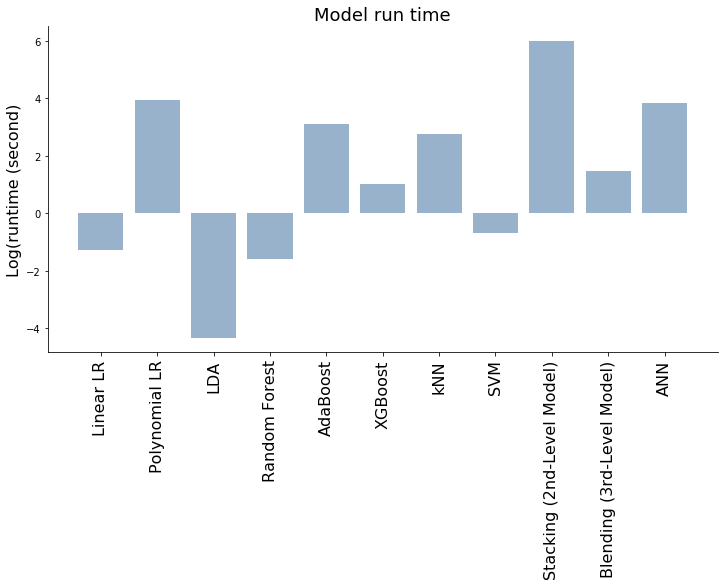

In [511]:
plt.figure(figsize=(12,6))
xx = range(len(df_var))
index_name=df_var.index
plt.bar(xx, np.log(df_var['training time(s)']),  alpha=0.5,color=(0.2, 0.4, 0.6, 0.6))
plt.title('Model run time', fontsize=18)
plt.ylabel('Log(runtime (second)', fontsize=16)
plt.xticks(xx,index_name,rotation=90,fontsize = 16);
sns.despine()

### Accuracy comparison


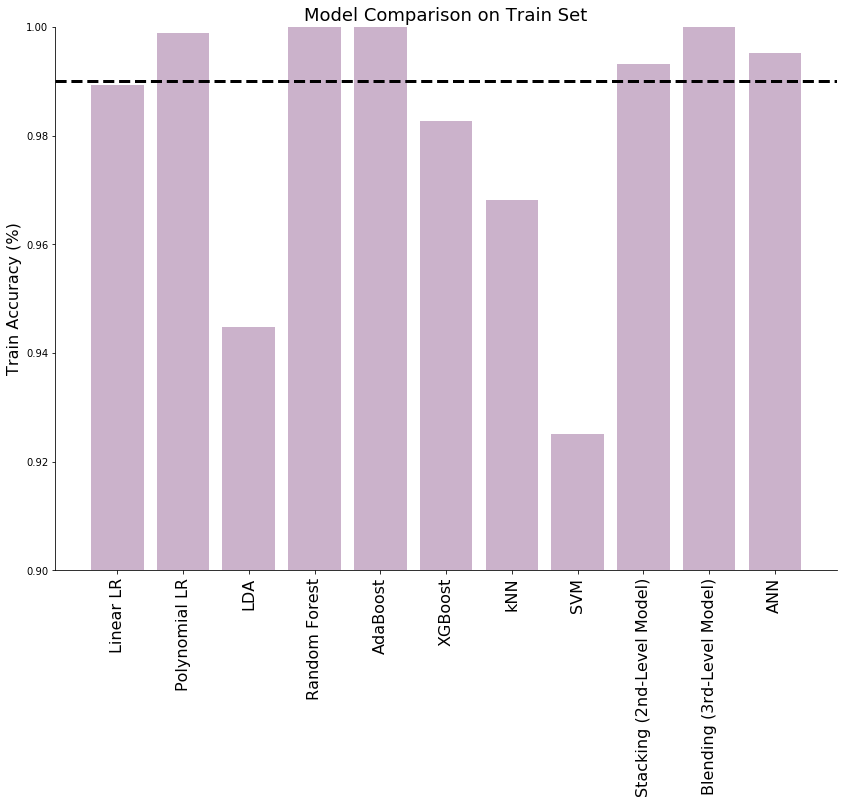

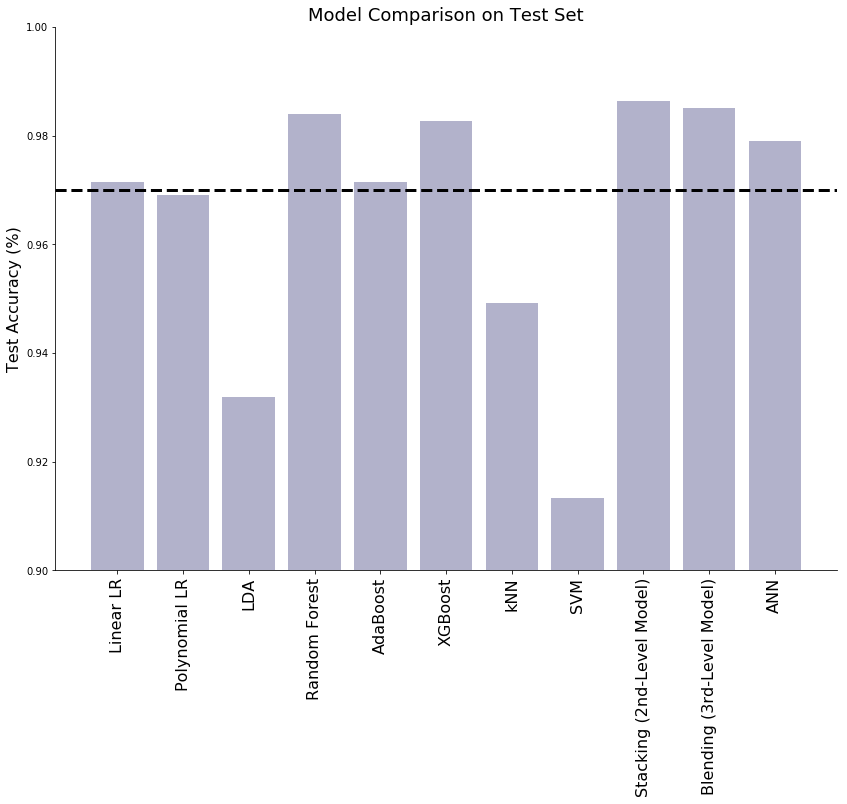

In [525]:
plt.figure(figsize=(14,10))
xx = range(len(df_var))
index_name=df_var.index
plt.bar(xx, df_var['train accuracy'], color=(0.6, 0.4, 0.6, 0.6), alpha=0.5)
plt.ylim(0.9,1)
plt.title('Model Comparison on Train Set', fontsize=18)
plt.ylabel('Train Accuracy (%)', fontsize=16)
plt.xticks(xx,index_name,rotation=90,fontsize = 16);
sns.despine()

plt.axhline(0.99, c='k', linewidth=3, linestyle='--');

plt.figure(figsize=(14,10))
xx = range(len(df_var))
index_name=df_var.index
plt.bar(xx, df_var['test accuracy'], color=(0.4, 0.4, 0.6, 0.6), alpha=0.5)
plt.ylim(0.9,1)
plt.title('Model Comparison on Test Set', fontsize=18)
plt.ylabel('Test Accuracy (%)', fontsize=16)
plt.xticks(xx,index_name,rotation=90,fontsize = 16);
plt.axhline(0.97, c='k', linewidth=3, linestyle='--');
sns.despine()

* In terms of the model runtime,  linear logistic regression (Linear LR), LDA , random forest and SVM take less than 1 second to run. Stacking is the slowest one, which takes 399 seconds to run. Actually, this is still not too bad for small dataset (1883 observations and  50 features) as in our case. If we need to run it for a huge dataset, we may need to consider the computational expense.


* In terms of the model accuracy, Polynomial logistic regression,  random fores, Adaboost, stacking, blending and ANN yield a training set accuray higher than 99%. The accuray score from the test set in random forest, Adaboost, XGBoost, stacking, blending and ANN are higher than 97%, which are really good.

* Overall, the advanced models with the NLP features perform really good. 

### Generating predictions for future usage

In [442]:
y_pre_df_NN_proba=y_pre_df_NN_proba.reshape(869,)

In [447]:
y_pre_df_NN_proba.shape
index = pre_df_scaled.index

In [448]:
index

Int64Index([ 876476261220179968,  909863671563739136,  951973545831223296,
             981943174947065856,          4735793156,  698968509091614720,
            1040722169574187010, 1019044289278443520,  821278120518946816,
            1003128394836578305,
            ...
                       40040033,            89265769,          2770095723,
                       21786220, 1044666765790334978,           559955566,
             870274473391398912,  930214719062908928,           594030193,
             850161357295112194],
           dtype='int64', name='User ID', length=869)

In [486]:
index = pre_df_scaled.index

pre_df_prediction_NLP = pd.DataFrame(np.column_stack([y_pre_df_logreg,y_pre_df_linearLogCVpoly,y_pre_df_rf,y_pre_df_adaboost,y_pre_df_xgboost,y_pred_df_best_k,y_pre_df_svm,pre_df_stacking,pre_df_blending,y_pre_df_NN,y_pre_df_logreg_proba,y_pre_df_linearLogCVpoly_proba,y_pre_df_rf_proba,y_pre_df_adaboost_proba,y_pre_df_xgboost_proba,y_pred_df_best_k_proba ,y_pre_dfsvm_proba,y_pre_df_NN_proba]), 
                               columns=[ 'Linear LR','Polynomial LR','Random Forest','AdaBoost','XGBoost','kNN','SVM','Stacking (2nd-Level Model)','Blending (3rd-Level Model)','ANN','Linear LR_prob','Polynomial LR_proba','Random Forest_proba','AdaBoost_proba','XGBoost_proba','kNN_proba','SVM_proba','ANN_proba'], index=index)
pre_df_prediction_NLP.to_csv('pre_df_prediction_NLP_2.csv')

In [490]:
pre_df_prediction_NLP.head()

,Linear LR,Polynomial LR,Random Forest,AdaBoost,XGBoost,kNN,SVM,Stacking (2nd-Level Model),Blending (3rd-Level Model),ANN,Linear LR_prob,Polynomial LR_proba,Random Forest_proba,AdaBoost_proba,XGBoost_proba,kNN_proba,SVM_proba,ANN_proba
User ID,,,,,,,,,,,,,,,,,,
876476261220179968,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.754798e-05,0.06,0.06,0.029001,0.00,0.023232,0.028690
909863671563739136,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.561330e-11,0.20,0.20,0.078705,0.00,0.019900,0.000459
951973545831223296,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.000000e+00,0.22,0.22,0.040030,0.25,0.010804,0.996794
981943174947065856,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.000000e+00,0.02,0.02,0.026049,0.00,0.230778,0.983321
4735793156,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.926822e-16,0.10,0.10,0.034885,0.00,0.020738,0.000020
